# Machine Learning Engineer Nanodegree
## Capstone Project
Ivan Chen
<br>December 26, 2017

## Topic: Attrition prediction with machine learning approach in human resource management

  In human resource management, HR professionals take the responsibility in designing suitable systems such as work culture, compensation or promotion system to help the company or organization to retain top employees. Attrition in human resources refers to the gradual loss in labor over time. 
  In general, average attrition rate compared with other companies in same business is acceptable but relatively high attrition may cause trouble for companies. A major problem in high attrition rate is high cost to an organization; for example, human resources team may need to start hiring processes, providing new hire training. Besides, to the organization, high attrition rate may lead to lose knowledge and experience; it may impact daily or business operation. Usually human resources teams take attrition rates as factors into their department budgets to account for potential losses in productivity and the costs with replacing employees.
Problem Statement
  The attrition rate is determined by dividing the number of employees who left the company or organization during a specific period by the number of employees during the same period. Attrition rate can be computed by monthly, quarterly or annual periods. Consistent rate of attrition is treat as the norm for a company but high attrition rate may induce trouble to a company. To predict and classify high attrition risk of employees are critical for human resources members. With the classified result human resources teams may evaluate the causes of attrition and find solutions. 
  The attrition prediction problem would be a binary classification problem and the goal of the project is to generate a relatively accurate model to predict attrition or stay of employees based on collected employees data. In the study, a solution was proposed and to be implemented. Benchmark model, evaluation metrics, key feature importance observation will be considered and discussed.


----
## Exploring the Data
  The dataset used in this project was downloaded from kaggle, (https://www.kaggle.com/ludobenistant/hr-analytics-1/data) which was provided by Ludovic benistant for HR Analytic study and practice. The dataset consists total 14999 rows with 10 columns. 
  <br>The last one “attrition” column renamed by me from “left” for this study was used as target label of the prediction. Other columns provide related information of the employee such as average monthly working hours, number of projects. 

In [71]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("HR_comma_sep.csv")

# Change column name of sales to Departments
data = data.rename(columns = {'sales': 'Departments'})
data = data.rename(columns = {'left': 'attrition'})
data = data.rename(columns = {'average_montly_hours': 'average_monthly_hours'}) # correct typo

# Display the some records
display(data.head(n=5))
data.info()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,attrition,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_monthly_hours    14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
attrition                14999 non-null int64
promotion_last_5years    14999 non-null int64
Departments              14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Implementation: Data Exploration
  Although the number of columns is not many but they provide important work related information of employees. Besides, the distribution of target variable “attrition” (76.2% is No, “23.8% is Yes) is unbalanced but I think  it is not skewed, so the dataset is suitable for this attrition prediction problem.

In [72]:
# Total number of records
n_records = data["attrition"].count()

n_attrition = int(0)
n_stay = int(0)
for i, left in enumerate(data["attrition"]):    
    #if ( left.strip() == '1'):
    if ( left == 1):        
        n_attrition += 1
    else:
        n_stay += 1
        
# Percentage of attrition
attrition_percent = float(n_attrition) / float(n_records)

print "Total number of records: {}".format(n_records)
print "Number of attrition: {}".format(n_attrition)
print "Number of stay (survival): {}".format(n_stay)
print "Percentage of attrition: {:.2f}%".format(attrition_percent*100) 

Total number of records: 14999
Number of attrition: 3571
Number of stay (survival): 11428
Percentage of attrition: 23.81%


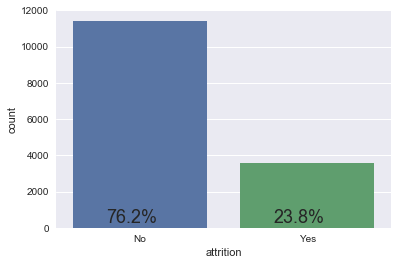

In [73]:
sns.countplot(data['attrition'])
plt.text(x = -.2, y = 300, s = str( np.round(1-attrition_percent, 3) *100) + '%', fontsize = 18)
plt.text(x = .8, y = 300, s = str( np.round(attrition_percent, 3) *100) + '%', fontsize = 18)
plt.xticks(np.arange(2),('No', 'Yes'))
plt.show()

** Features Exploration **
<br>
  Column name:	Meaning	Type,	Possible value

* **satisfaction_level**:	Satisfaction Level,	numerical,	float
* **last_evaluation**:	Last evaluation,	numerical,	float
* **number_project**:	Number of projects,	numerical,	integer
* **average_monthly_hours**:	Average monthly hours,	numerical,	float
* **time_spend_company**:	Time spent at the company,	numerical,	float
* **Work_accident**:	Whether they have had a work accident,	numerical,	Binary, 1 denotes 'Yes', 0 denotes 'No'.
* **promotion_last_5years**:	Whether they have had a promotion in the last 5 years,	numerical,	Binary, 1 denotes 'Yes', 0 denotes 'No'.
* **Departments (original column name: sales)**:	Departments,	categorical	sales, accounting, hr, technical, support, management, IT, product_mgn, marketing, RandD.
* **salary**:	Salary,	categorical	low, medium, high.


** Target label **
<br>
* **attrition** (original column name: left): Whether the employee has left, numerical, Binary, 1 denotes 'Yes', 0 denotes 'No'.

----
## Preparing the Data


### Transforming Skewed Continuous Features


In [74]:

# Split the data into features and target label
attrition_raw = data['attrition']
features_raw = data.drop('attrition', axis = 1)

# Drop columns without information
# All columns are informative

# Making categorical and numerical data frames
categorical = []
numerical = []
for column in features_raw:
    if type(features_raw[column][1]) == str:
        categorical.append(column)
    
    else:
        numerical.append(column)
        
numerical_df = features_raw[numerical]
categorical_df = features_raw[categorical]
print "Number of numerical features:", len(numerical)
display( numerical_df.head(5))
print "Number of categorical features:", len(categorical)
display( categorical_df.head(5))

Number of numerical features: 7


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years
0,0.38,0.53,2,157,3,0,0
1,0.80,0.86,5,262,6,0,0
2,0.11,0.88,7,272,4,0,0
3,0.72,0.87,5,223,5,0,0
4,0.37,0.52,2,159,3,0,0


Number of categorical features: 2


,Departments,salary
0,sales,low
1,sales,medium
2,sales,medium
3,sales,low
4,sales,low


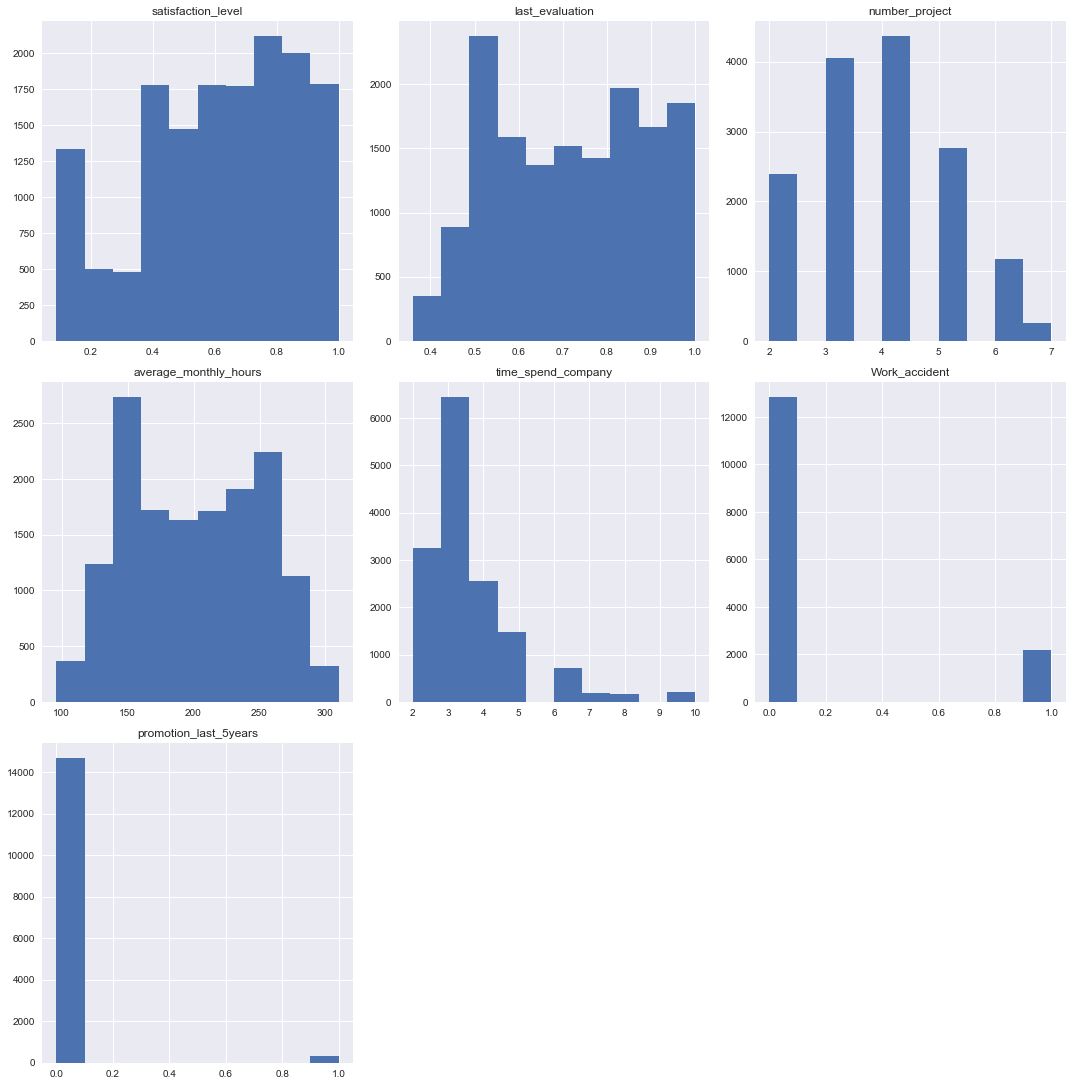

In [75]:
# histograms of the numerical data
fig = plt.figure(figsize = (15, 30))
i = 0
for column in numerical_df:
    i += 1
    fig.add_subplot(6, 3, i)
    plt.hist(numerical_df[column])
    plt.title(column)
plt.tight_layout()

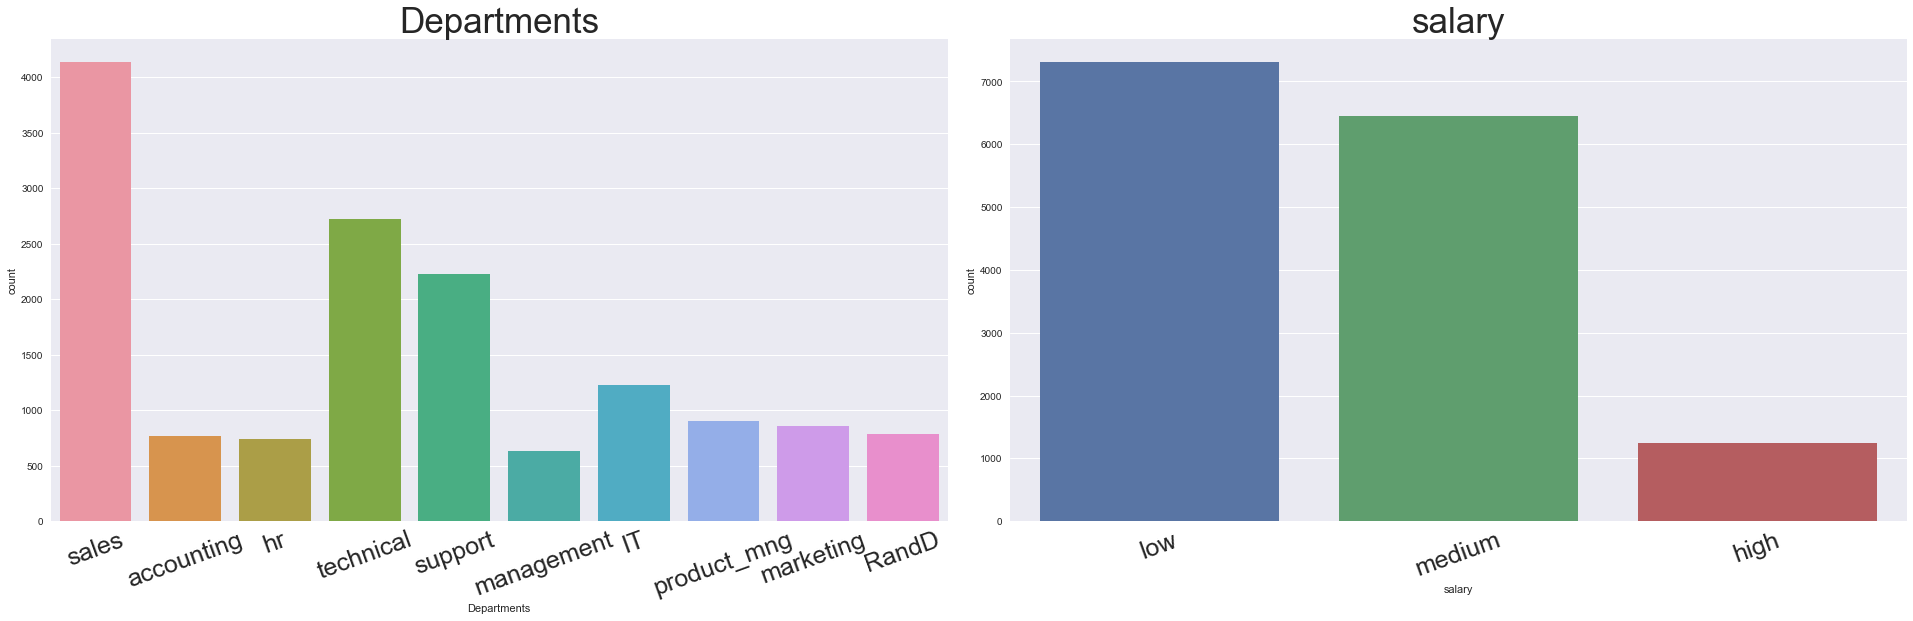

In [76]:
fig = plt.figure(figsize = (40, 40))
i = 0

for col in categorical_df:
    i += 1
    fig.add_subplot(5, 3, i)
    sns.countplot(categorical_df[col])
    plt.xticks(rotation=20, fontsize = 25)
    plt.title(col, fontsize = 35)
    
plt.tight_layout()

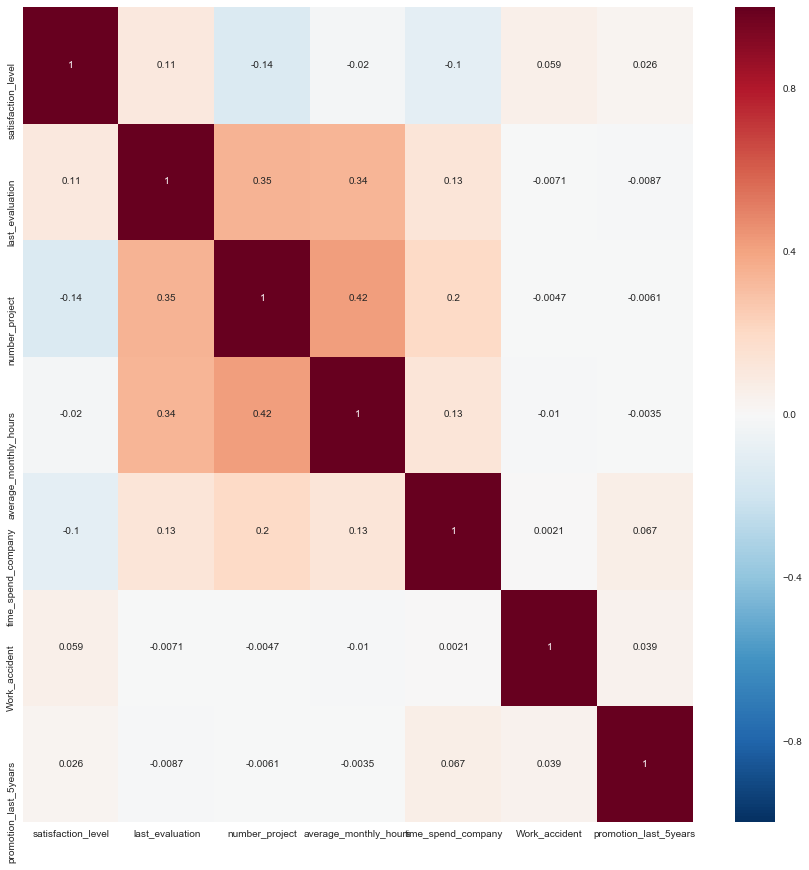

In [77]:
cor = numerical_df.corr()
plt.figure(figsize = (15,15))
sns.heatmap(cor, annot = True)
plt.show()

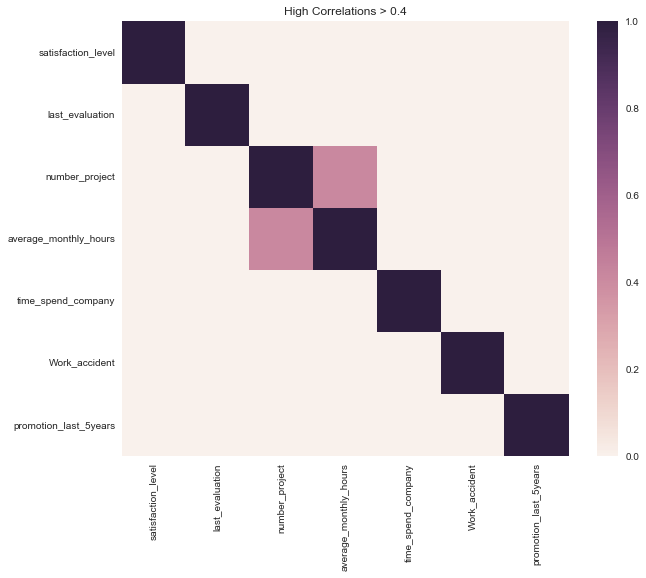

In [78]:
plt.figure(figsize = (10,8))
nThresholdCor = 0.4
big_cor = cor.where(abs(cor) > nThresholdCor)
sns.heatmap(big_cor.replace(np.nan, 0))
plt.title( 'High Correlations > ' + str(nThresholdCor))
plt.show()

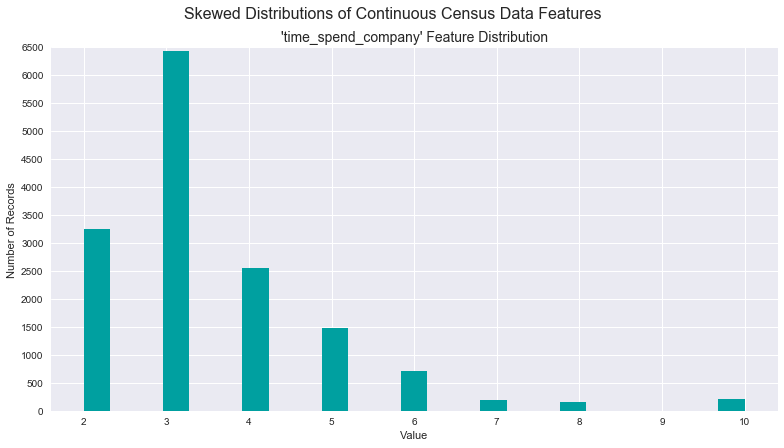

In [79]:
# Visualize skewed continuous features of original data
#vs.distribution(data)
skewed = ['time_spend_company']
vs.distribution(data, skewed)

    In this dataset, the feature “time_spend_company” is a little skewed. A common method to avoid outliers to negatively affect the performance of a learning algorithms is applying logarithmic transformation on the data. We can see the range of distribution was narrowed. 

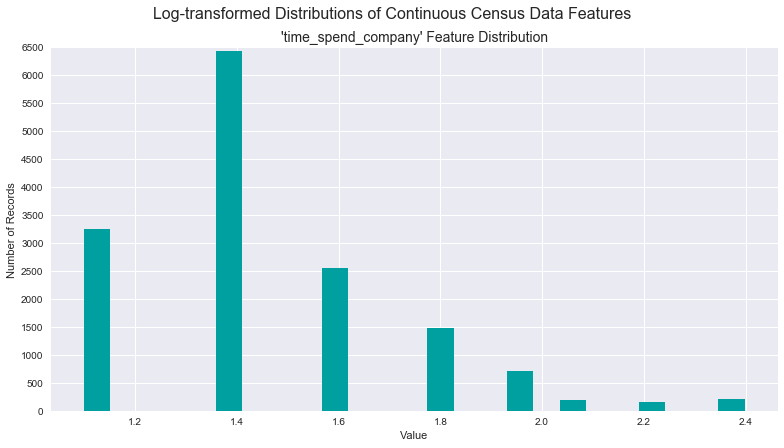

In [80]:
# Log-transform the skewed features
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, skewed, transformed = True)

### Normalizing Numerical Features
To ensure that each feature is treated equally when applying supervised learners, scaling was applied on all numerical features including 'satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours' and 'time_spend_company'. Two numerical features 'Work_accident', 'promotion_last_5years' are numerical but they are binary values, either 1 or 0 that denotes “Yes” and “No”, so they are no needed to apply scaling. Applying a scaling to the data does not change the shape of each feature's distribution.

In [81]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
#numerical = ['Age']
print numerical

# remove binary features
numerical.remove('Work_accident')
numerical.remove('promotion_last_5years')
print numerical
#display(features_log_minmax_transform.head(5))

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years']
['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'time_spend_company']


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,promotion_last_5years,Departments,salary
0,0.318681,0.265625,0.0,0.285047,0.221416,0,0,sales,low
1,0.780220,0.781250,0.6,0.775701,0.652127,0,0,sales,medium
2,0.021978,0.812500,1.0,0.822430,0.393160,0,0,sales,medium
3,0.692308,0.796875,0.6,0.593458,0.533484,0,0,sales,low
4,0.307692,0.250000,0.0,0.294393,0.221416,0,0,sales,low


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |


 - Convert the target label `'attrition_raw'` to numerical entries.
   - Set records with "No" to `0` and records with "Yes" to `1`.

In [82]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
#print(len(list(features_log_minmax_transform)))
features_final = pd.get_dummies( features_log_minmax_transform )
print(features_final.head())

# TODO: Encode the 'attrition_raw' data to numerical values
#print(attrition_raw.head(10))
attrition = pd.DataFrame(data = attrition_raw)
#attrition = attrition_raw.apply(lambda x: 0 if x ==0 else 1)
#print(attrition.head(5))

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
#print encoded

   satisfaction_level  last_evaluation  number_project  average_monthly_hours  \
0            0.318681         0.265625             0.0               0.285047   
1            0.780220         0.781250             0.6               0.775701   
2            0.021978         0.812500             1.0               0.822430   
3            0.692308         0.796875             0.6               0.593458   
4            0.307692         0.250000             0.0               0.294393   

   time_spend_company  Work_accident  promotion_last_5years  Departments_IT  \
0            0.221416              0                      0               0   
1            0.652127              0                      0               0   
2            0.393160              0                      0               0   
3            0.533484              0                      0               0   
4            0.221416              0                      0               0   

   Departments_RandD  Departments_acco

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [83]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'attrition' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    attrition, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 11999 samples.
Testing set has 3000 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor


$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).




#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Naive Predictor Performace


In [84]:
'''
TP = np.sum(attrition) # Counting the ones as this is the naive case. Note that 'attrition' is the 'attrition_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = attrition.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''
attrition_count = int(attrition.count())
TP = int(np.sum(attrition))
FP = int(attrition_count) - TP
TN = int(0)
FN = int(0)
print"#total_data:{}, TP:{}, FP:{}".format(attrition_count, TP, FP)

# TODO: Calculate accuracy, precision and recall
accuracy = float(TP+TN)/ attrition_count
recall = float(TP)/(TP+FN)
precision = float(TP)/(TP+FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# HINT: The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
beta = 0.5
fscore = (1 + beta**2)*(precision * recall) / ((beta**2 * precision) + recall)

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

#total_data:14999, TP:3571, FP:11428
Naive Predictor: [Accuracy score: 0.2381, F-score: 0.2809]


###  Supervised Learning Models


### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data.

In [85]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: attrition training set
       - X_test: features testing set
       - y_test: attrition testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end-start
    #print "train_time: %.2f seconds" % (results['train_time'])
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict( X_test )
    predictions_train = learner.predict( X_train[:300] )
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end-start
    #print "pred_time: %.2f seconds" % (results['pred_time'])

    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score( y_train[:300], predictions_train )
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score( y_test, predictions_test )
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score( y_train[:300], predictions_train, 0.5)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score( y_test, predictions_test, 0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation


DecisionTreeClassifier ...
DecisionTreeClassifier trained on 119 samples.
DecisionTreeClassifier trained on 1199 samples.
DecisionTreeClassifier trained on 11999 samples.
SVC ...
SVC trained on 119 samples.
SVC trained on 1199 samples.
SVC trained on 11999 samples.
AdaBoostClassifier ...
AdaBoostClassifier trained on 119 samples.
AdaBoostClassifier trained on 1199 samples.
AdaBoostClassifier trained on 11999 samples.
Done


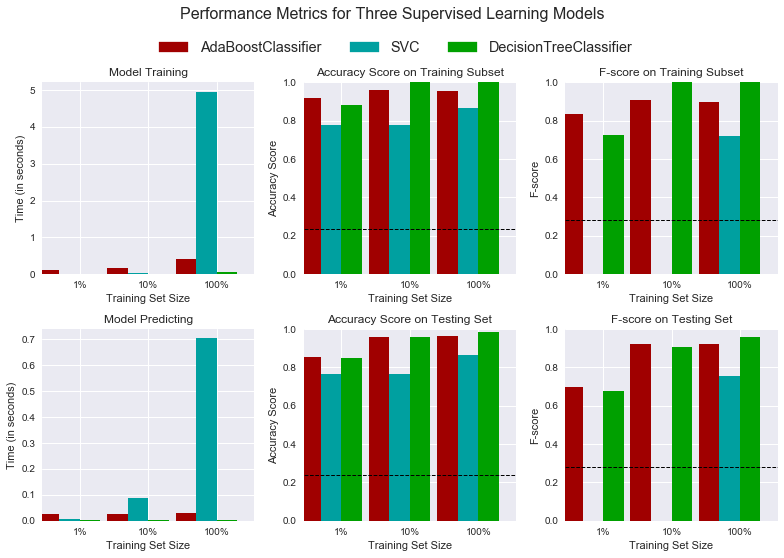

		train_time	acc_test	f_test

samples_ 119
AdaBoostClassifier
		0.11		0.85		0.70
SVC
		0.00		0.77		0.00
DecisionTreeClassifier
		0.00		0.85		0.68

samples_ 1199
AdaBoostClassifier
		0.16		0.96		0.92
SVC
		0.04		0.77		0.00
DecisionTreeClassifier
		0.00		0.96		0.91

samples_ 11999
AdaBoostClassifier
		0.42		0.96		0.92
SVC
		4.96		0.87		0.76
DecisionTreeClassifier
		0.06		0.98		0.96


In [86]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# TODO: Initialize the three models
clf_A = DecisionTreeClassifier( random_state = 0 )
clf_B = SVC()
#clf_C = BaggingClassifier( KNeighborsClassifier(), max_samples=0.5, max_features=0.5 )
clf_C = AdaBoostClassifier()
#clf_C = clf_A

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
samples_100 = len(y_train)
samples_10 = samples_100/ 10
samples_1 = samples_100/100

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
#for clf in [clf_A, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    print clf_name, "..."
    for i, samples in enumerate([samples_1, samples_10, samples_100 ]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)
print "Done"
        
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

lst_samples = [samples_1, samples_10, samples_100 ]
print "\t\ttrain_time\tacc_test\tf_test"
for j in range(3):
    print "\nsamples_", lst_samples[j]
    print "======================================================"
    for i, clf_name in enumerate(list(results.keys())):        
        print "{}".format(clf_name) 
        print "\t\t{:,.2f}\t\t{:,.2f}\t\t{:,.2f}".format(results[clf_name][j]['train_time'], results[clf_name][j]['acc_test'], results[clf_name][j]['f_test'])            

----
## Improving Results


### Choosing the Best Model


### Implementation: Model Tuning


In [87]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
#from sklearn.linear_model import LogisticRegression

# TODO: Initialize the classifier
clf = clf_A

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
parameters = {'max_depth': range(1, 10)}
#parameters = {'n_estimators': [10, 50, 70] }
#parameters = {'n_estimators': [(x+1)*10 for x in range(20)]}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer( fbeta_score, beta=0.5 )

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV( clf, parameters, scorer )

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit( X_train, y_train.values.ravel())

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print("Best parameters:", grid_obj.best_params_)
print "Unoptimized model\n------"
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))

print "\nOptimized Model\n------"
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))


('Best parameters:', {'max_depth': 7})
Unoptimized model
------
F-score on testing data: 0.9561
Accuracy score on testing data: 0.9827

Optimized Model
------
Final F-score on the testing data: 0.9685
Final accuracy score on the testing data: 0.9787


### Final Model Evaluation

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| F-score        |    0.956          |   0.968         |
| Accuracy Score |    0.982          |   0.978         |

The optimized model's F-score is 0.968 and accuracy is 0.978. These scores are better than the unoptimized model whose F-score is 0.956 and accuracy is.
The naive predictor's F-score is 0.28 and accuracy score is 0.238. The optimized model's scores are much better than naive predictor's.
<br>
Naive Predictor: [F-score: 0.2809, Accuracy score: 0.2381]


----
## Feature Importance


### Feature Relevance Observation


### Implementation - Extracting Feature Importance


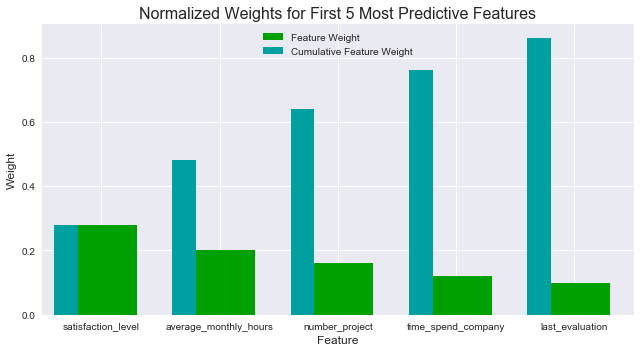

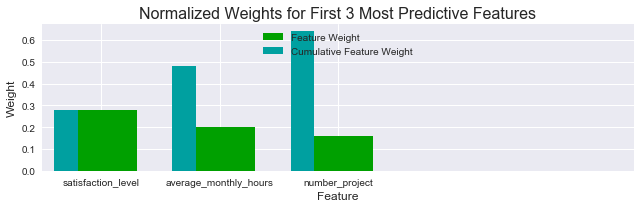

In [88]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
nFeatures = 5
vs.feature_plot(importances, X_train, y_train, nFeatures)

nFeatures = 3
vs.feature_plot(importances, X_train, y_train, nFeatures)

### Extracting Feature Importance



### Feature Selection


In [89]:
# Import functionality for cloning a model
from sklearn.base import clone

nFeatures = 3
# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:nFeatures]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:nFeatures]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))

print "\nFinal Model trained on reduced data\n------"
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))

Final Model trained on full data
------
F-score on testing data: 0.9685
Accuracy on testing data: 0.9787

Final Model trained on reduced data
------
F-score on testing data: 0.8780
Accuracy on testing data: 0.9373


### Final Model Evaluation

|     Metric     | Model trained on full data | Model trained on reduced data|
| :------------: | :---------------: | :-------------: | 
| F-score        |    0.968          |   0.878         |
| Accuracy Score |    0.978          |   0.937         |